In [23]:

!pip install optuna==3.3.0 #wichtig: nutzer Version 3.3, da sonst keine kompatibilität mit pytorch_lightning, siehe https://github.com/optuna/optuna/issues/4935

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
import PIL.ImageOps
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
import optuna

In [25]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform
        self.augmentation = self.random_augmentation()

    def __getitem__(self, index):
        img0_tuple = random.choice(self.image_folder_dataset.imgs)
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                # Keep looping till the same class image is found
                img1_tuple = random.choice(self.image_folder_dataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # Keep looping till a different class image is found
                img1_tuple = random.choice(self.image_folder_dataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0_path = img0_tuple[0]
        img1_path = img1_tuple[0]

        # Label: 0 for same class, 1 for different class
        label = torch.tensor([int(img0_tuple[1] != img1_tuple[1])], dtype=torch.float32)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        else:
            img0 = self.augmentation(img0)
            img1 = self.augmentation(img1)

        return img0, img1, img0_path, img1_path, label

    def __len__(self):
        return len(self.image_folder_dataset.imgs)

    def random_augmentation(self):
        augmentations = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
        ]
        return transforms.Compose([
            random.choice(augmentations),
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

In [26]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()

        # Convolutional layers with BatchNormalization
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(64),  # BatchNormalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),  # BatchNormalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )

        # Fully connected layers with BatchNormalization
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [27]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [28]:
def fit(model, epoch_number, train_dataloader, val_dataloader, optimizer, criterion_name, device, treshold):
    loss_history = []

    print("Begin Training")

    for epoch in range(epoch_number):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (img0, img1, img0_path, img1_path, labels) in enumerate(train_dataloader):
            img0, img1, labels = img0.to(device), img1.to(device), labels.to(device)

            optimizer.zero_grad()

            output1 = model(img0)
            output2 = model(img1)

            if(criterion_name == "BCELoss"):
              criterion = nn.BCEWithLogitsLoss()
              labels = labels.view(-1)
              output = F.pairwise_distance(output1, output2)
              loss = criterion(output, labels)

            if(criterion_name == "Constrative"):
              criterion = ContrastiveLoss(margin=1.0)
              loss = criterion(output1, output2, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train += labels.size(0)

        train_loss = total_train_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epoch_number}, Train Loss: {train_loss:.4f}")
        writer.add_scalar('training loss', train_loss / 100, epoch * len(train_dataloader) + batch_idx)

        loss_history.append(train_loss)
        validate(model, val_dataloader, device, treshold)

In [29]:
def validate(model, val_dataloader, device, treshold):
    model.eval()  # Set the model to evaluation mode (e.g., BatchNorm behaves differently).
    correct = 0.0
    total = 0.0

    with torch.no_grad():
        for batch_idx, (img1, img2, img0_path, img1_path, labels) in enumerate(val_dataloader):
          labels = labels.view(-1, 1).float()
          img1 = img1.to(device)
          img2 = img2.to(device)
          labels = labels.to(device)
          img1 = Variable(img1)
          img2 = Variable(img2)
          labels = Variable(labels)

          output1 = model(img1)
          output2 = model(img2)
          euclidean_distance = F.pairwise_distance(output1, output2)
          predicted = torch.tensor([0 if sd < treshold else 1 for sd in euclidean_distance]).to(device)
          output_labels = predicted.to(labels.dtype)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    accuracy = 100 * (correct / total)
    print('Validation Accuracy of the network: {:.2f}%'.format(accuracy))


In [30]:
def predict(model, val_dataloader, device, treshold):
    model.eval()
    correct = 0.0
    total = 0.0
    true_labels = []
    predicted_labels = []
    distance = []
    img1_paths = []
    img2_paths = []

    with torch.no_grad():
        for batch_idx, (img1, img2, img1_path, img2_path, labels) in enumerate(val_dataloader):
          labels = labels.view(-1, 1).float()
          img1 = img1.to(device)
          img2 = img2.to(device)
          labels = labels.to(device)
          img1 = Variable(img1)
          img2 = Variable(img2)
          labels = Variable(labels)

          output1 = model(img1)
          output2 = model(img2)
          euclidean_distance = F.pairwise_distance(output1, output2)
          predicted = torch.tensor([0 if sd < treshold else 1 for sd in euclidean_distance]).to(device)
          output_labels = predicted.to(labels.dtype)
          true_labels.append(int(labels))
          predicted_labels.append(int(predicted))
          distance.append(float(euclidean_distance))
          img1_paths.append(img1_path)
          img2_paths.append(img2_path)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    accuracy = 100 * (correct / total)
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))

    evaluation_df = pd.DataFrame({
    'Image1 Path': img1_paths,
    'Image2 Path': img2_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels,
    'Distance': distance })

    return evaluation_df


In [37]:
# Function for Hyperparameter Optimization (learning rate only)
def objective(trial):
    # Define the learning rate hyperparameter to be optimized
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Re-initialize the model and optimizer with the new learning rate
    siamese_model = SiameseNeuralNetwork().to(device)
    optimizer = optim.Adam(siamese_model.parameters(), lr=learning_rate)

    # Hier eventuell epoch_number herabsetzen falls es zu lange dauert!

    # Train the model
    fit(siamese_model, 5, train_dataloader, val_dataloader, optimizer, "Constrative", device, treshold)

    # Evaluate the model
    evaluation_df = predict(siamese_model, test_dataloader, device, treshold)
    true_labels = np.array(evaluation_df['True Label'])
    predicted_labels = np.array(evaluation_df['Predicted Label'])
    accuracy = 100 * (np.sum(true_labels == predicted_labels) / len(true_labels))

    return accuracy

[I 2024-07-06 15:57:36,920] A new study created in memory with name: no-name-3f4fdba2-7bf3-4e3a-bda8-e4b222aa4b59


Number of trainable parameters 185920
Begin Training


<ipython-input-35-2e72b2db51fa>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


Epoch 1/3, Train Loss: 0.2346
Validation Accuracy of the network: 63.15%
Epoch 2/3, Train Loss: 0.1821
Validation Accuracy of the network: 77.00%
Epoch 3/3, Train Loss: 0.1627
Validation Accuracy of the network: 74.15%


[I 2024-07-06 16:02:57,515] Trial 0 finished with value: 71.26436781609196 and parameters: {'learning_rate': 0.0010485949003185325}. Best is trial 0 with value: 71.26436781609196.


Accuracy of the network on the test set: 71.26%
Begin Training
Epoch 1/3, Train Loss: 0.2724
Validation Accuracy of the network: 60.20%
Epoch 2/3, Train Loss: 0.2263
Validation Accuracy of the network: 62.60%
Epoch 3/3, Train Loss: 0.1999
Validation Accuracy of the network: 70.05%


[I 2024-07-06 16:05:28,118] Trial 1 finished with value: 67.56621689155422 and parameters: {'learning_rate': 0.013805358825525992}. Best is trial 0 with value: 71.26436781609196.


Accuracy of the network on the test set: 67.57%
Begin Training
Epoch 1/3, Train Loss: 0.4968
Validation Accuracy of the network: 50.60%
Epoch 2/3, Train Loss: 0.5025
Validation Accuracy of the network: 50.15%
Epoch 3/3, Train Loss: 0.4870
Validation Accuracy of the network: 51.85%


[I 2024-07-06 16:07:36,624] Trial 2 finished with value: 49.525237381309346 and parameters: {'learning_rate': 0.04726549646604065}. Best is trial 0 with value: 71.26436781609196.


Accuracy of the network on the test set: 49.53%
Begin Training
Epoch 1/3, Train Loss: 0.2277
Validation Accuracy of the network: 69.40%
Epoch 2/3, Train Loss: 0.1790
Validation Accuracy of the network: 71.10%
Epoch 3/3, Train Loss: 0.1697
Validation Accuracy of the network: 75.00%


[I 2024-07-06 16:09:44,448] Trial 3 finished with value: 70.26486756621689 and parameters: {'learning_rate': 0.0019764053184216103}. Best is trial 0 with value: 71.26436781609196.


Accuracy of the network on the test set: 70.26%
Begin Training
Epoch 1/3, Train Loss: 0.2267
Validation Accuracy of the network: 66.55%
Epoch 2/3, Train Loss: 0.2037
Validation Accuracy of the network: 69.65%
Epoch 3/3, Train Loss: 0.1618
Validation Accuracy of the network: 73.85%


[I 2024-07-06 16:11:50,809] Trial 4 finished with value: 72.31384307846078 and parameters: {'learning_rate': 0.00038461832722708656}. Best is trial 4 with value: 72.31384307846078.


Accuracy of the network on the test set: 72.31%
Begin Training
Epoch 1/3, Train Loss: 0.2178
Validation Accuracy of the network: 69.85%
Epoch 2/3, Train Loss: 0.1600
Validation Accuracy of the network: 69.05%
Epoch 3/3, Train Loss: 0.1583
Validation Accuracy of the network: 76.15%


[I 2024-07-06 16:13:57,445] Trial 5 finished with value: 73.41329335332334 and parameters: {'learning_rate': 0.0005572206221427243}. Best is trial 5 with value: 73.41329335332334.


Accuracy of the network on the test set: 73.41%
Begin Training
Epoch 1/3, Train Loss: 0.3055
Validation Accuracy of the network: 58.00%
Epoch 2/3, Train Loss: 0.2871
Validation Accuracy of the network: 59.75%
Epoch 3/3, Train Loss: 0.2452
Validation Accuracy of the network: 62.35%


[I 2024-07-06 16:16:06,370] Trial 6 finished with value: 61.019490254872565 and parameters: {'learning_rate': 0.01832489768555691}. Best is trial 5 with value: 73.41329335332334.


Accuracy of the network on the test set: 61.02%
Begin Training
Epoch 1/3, Train Loss: 0.2397
Validation Accuracy of the network: 64.95%
Epoch 2/3, Train Loss: 0.2097
Validation Accuracy of the network: 68.95%
Epoch 3/3, Train Loss: 0.1753
Validation Accuracy of the network: 74.60%


[I 2024-07-06 16:18:13,791] Trial 7 finished with value: 73.86306846576711 and parameters: {'learning_rate': 0.00013278971804407216}. Best is trial 7 with value: 73.86306846576711.


Accuracy of the network on the test set: 73.86%
Begin Training
Epoch 1/3, Train Loss: 0.1980
Validation Accuracy of the network: 70.70%
Epoch 2/3, Train Loss: 0.1800
Validation Accuracy of the network: 65.15%
Epoch 3/3, Train Loss: 0.1657
Validation Accuracy of the network: 74.90%


[I 2024-07-06 16:20:20,201] Trial 8 finished with value: 70.66466766616692 and parameters: {'learning_rate': 0.001730085757944138}. Best is trial 7 with value: 73.86306846576711.


Accuracy of the network on the test set: 70.66%
Begin Training
Epoch 1/3, Train Loss: 0.4964
Validation Accuracy of the network: 50.00%
Epoch 2/3, Train Loss: 0.4865
Validation Accuracy of the network: 50.50%
Epoch 3/3, Train Loss: 0.5070
Validation Accuracy of the network: 50.75%


[I 2024-07-06 16:22:26,918] Trial 9 finished with value: 50.774612693653175 and parameters: {'learning_rate': 0.08681507621785275}. Best is trial 7 with value: 73.86306846576711.


Accuracy of the network on the test set: 50.77%
Best learning rate: 0.00013278971804407216 with accuracy: 73.86%
Begin Training
Epoch 1/10, Train Loss: 0.2430
Validation Accuracy of the network: 64.00%
Epoch 2/10, Train Loss: 0.2132
Validation Accuracy of the network: 70.80%
Epoch 3/10, Train Loss: 0.1682
Validation Accuracy of the network: 74.30%
Epoch 4/10, Train Loss: 0.1705
Validation Accuracy of the network: 74.30%
Epoch 5/10, Train Loss: 0.1571
Validation Accuracy of the network: 78.80%
Epoch 6/10, Train Loss: 0.1506
Validation Accuracy of the network: 78.20%
Epoch 7/10, Train Loss: 0.1423
Validation Accuracy of the network: 77.05%
Epoch 8/10, Train Loss: 0.1410
Validation Accuracy of the network: 80.15%
Epoch 9/10, Train Loss: 0.1478
Validation Accuracy of the network: 79.80%
Epoch 10/10, Train Loss: 0.1452
Validation Accuracy of the network: 77.95%
Accuracy of the network on the test set: 76.46%


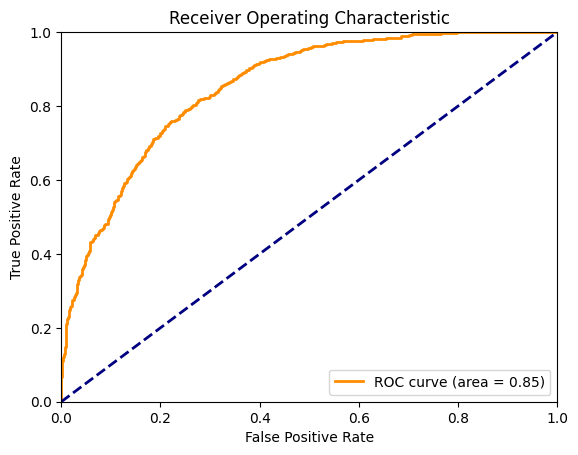

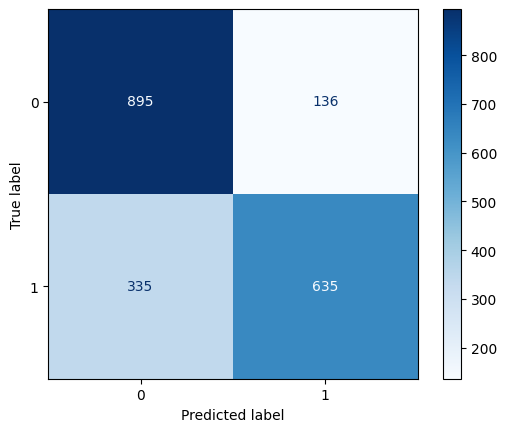

In [36]:
# Step 1: Define Path to Training, Validation and Test Images
path_to_train_images = "/content/drive/MyDrive/image_data/small_training"
path_to_validation_images = "/content/drive/MyDrive/image_data/small_validation"
path_to_test_images = "/content/drive/MyDrive/image_data/small_test"

# Step 2: Load the training, validation and test dataset with ImageFolder
train_dataset = datasets.ImageFolder(path_to_train_images)
val_dataset = datasets.ImageFolder(path_to_validation_images)
test_dataset = datasets.ImageFolder(path_to_test_images)

writer = SummaryWriter('runs/example_experiment')

# Step 4: Device configuration (usage of GPU --> if possible!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 5: Resize the images and transform to tensors
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

transformation_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

# Step 3: Initialize the Network Data Loader for training and validation
siamese_train_dataset = SiameseNetworkDataset(train_dataset, transform=transformation_val)
siamese_val_dataset = SiameseNetworkDataset(val_dataset, transform=transformation_val)
siamese_test_dataset = SiameseNetworkDataset(test_dataset, transform=transformation_val)

# Step 4: Device configuration (usage of GPU --> if possible!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 5: Create Siamese Model and print out Network Summary
siamese_model = SiameseNeuralNetwork().to(device)
total_params = sum(p.numel() for p in siamese_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters {total_params}")

# Step 6: Define Hyperparameters (epoch, batch_size, loss etc.)
batch_size = 40
epoch_number = 10
treshold = 0.5


# Step 7: Load Training and Validation Dataset
train_dataloader = DataLoader(siamese_train_dataset,
                              shuffle=True,
                              batch_size=batch_size)

val_dataloader = DataLoader(siamese_val_dataset,
                            shuffle=False,
                            batch_size=1)

test_dataloader = DataLoader(siamese_test_dataset,
                             shuffle=False,
                             batch_size=1)

# Optimize the learning rate using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  #, timeout=3600)  # 1 hour limit

print(f"Best learning rate: {study.best_params['learning_rate']} with accuracy: {study.best_value:.2f}%")

# Step 9: Plot ROC Curve with the best model
best_learning_rate = study.best_params['learning_rate']
siamese_model = SiameseNeuralNetwork().to(device)
optimizer = optim.Adam(siamese_model.parameters(), lr=best_learning_rate)

#Step 8: Start training and testing
fit(siamese_model, epoch_number, train_dataloader, val_dataloader, optimizer, "Constrative", device, treshold)
evaluation_df = predict(siamese_model, test_dataloader, device, treshold)


true_labels = np.array(evaluation_df['True Label'])
predicted_labels = np.array(evaluation_df['Predicted Label'])
distances = np.array(evaluation_df['Distance'])
evaluation_df.to_csv("evaluation.csv", index=False, sep=";")

distance_prob = 1 - distances

fpr, tpr, thresholds = roc_curve(true_labels, distance_prob, pos_label=0)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC.png")
# Step 10: Print Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("ConfusionMatrix.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')